In [1]:

import time

from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from azure.cognitiveservices.vision.computervision.models import OperationStatusCodes
from msrest.authentication import CognitiveServicesCredentials

'''
Authenticate
Authenticates your credentials and creates a client.
'''
# subscription_key = os.environ["VISION_KEY"]
subscription_key = ""
# endpoint = os.environ["VISION_ENDPOINT"]
endpoint = ""
computervision_client = ComputerVisionClient(endpoint, CognitiveServicesCredentials(subscription_key))
'''
END - Authenticate
'''

'\nEND - Authenticate\n'

In [2]:
def get_response(img):
    read_response_value = computervision_client.read_in_stream(
        image=img,
        mode="Printed",
        raw=True
    )
    return read_response_value


def get_read_result(read_response_arg):
    operation_id = read_response_arg.headers['Operation-Location'].split('/')[-1]
    while True:
        read_result_value = computervision_client.get_read_result(operation_id)
        if read_result_value.status not in ['notStarted', 'running']:
            break
        time.sleep(1)

    return read_result_value

#(x1, y1, x2, y2, x3, y3, x4, y4)
def get_data(read_result_arg):
    result = []
    min_x = min_y = float('inf')
    max_x = max_y = float('-inf')
    if read_result_arg.status == OperationStatusCodes.succeeded:
        for text_result in read_result_arg.analyze_result.read_results:
            for line in text_result.lines:
                min_x = min(line.bounding_box[0], line.bounding_box[6], min_x)
                min_y = min(line.bounding_box[1], line.bounding_box[3], min_y)
                max_x = max(line.bounding_box[2], line.bounding_box[4], max_x)
                max_y = max(line.bounding_box[5], line.bounding_box[7], max_y)
                result.append(line.text)

    return (min_x, min_y, max_x, max_y), result

In [3]:
def levenshtein(g, t):
    v0 = [i for i in range(0, len(t) + 1)]
    v1 = [0] * (len(t) + 1)

    for i in range(len(g)):
        v1[0] = i + 1

        for j in range(0, len(t)):
            d = v0[j + 1] + 1
            insert = v1[j] + 1
            if g[i] == t[j]:
                s = v0[j]
            else:
                s = v0[j] + 1

            v1[j + 1] = min(d, insert, s)

        v0, v1 = v1, v0

    return v0[-1]


def er_lev(ground_truth, processed_word):
    distance = levenshtein(ground_truth, processed_word)
    print("Distance levensthein", distance)
    return distance / len(ground_truth)


def padding(ground_truth, processed):
    max_len = max(len(ground_truth), len(processed))
    if type(ground_truth) == str:
        return ground_truth.ljust(max_len), processed.ljust(max_len)
    elif type(ground_truth) == list:
        return ground_truth + [""] * (max_len - len(ground_truth)), processed + [""] * (max_len - len(processed))


def hamming(ground_truth: str, processed: str):
    ground_truth, processed = padding(ground_truth, processed)

    return sum(c1 != c2 for c1, c2 in zip(ground_truth, processed))


def er_hamming(ground_truth, processed_word):
    distance = hamming(ground_truth, processed_word)
    return distance / len(ground_truth)

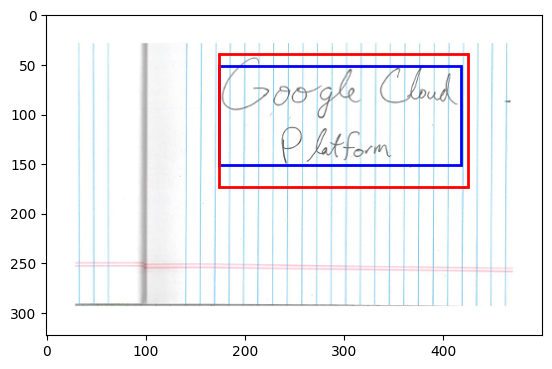

CER folosind Hamming 0.0 pe textul ['Google Cloud', 'Platform']
WER folosind Hamming 0.0 pe textul ['Google Cloud', 'Platform']
Distance levensthein 0
CER folosind Levenshtein 0.0 pe textul ['Google Cloud', 'Platform']
Distance levensthein 0
WER folosind Levenshtein 0.0 pe textul ['Google Cloud', 'Platform']
IoU 72.54563834215378%


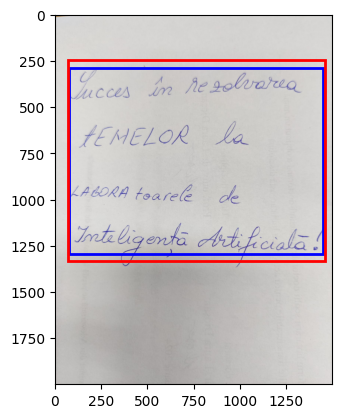

CER folosind Hamming 0.5428571428571428 pe textul ['Lucces in resolvarea', 'TEMELOR la', 'LABORA toarele de', 'Inteligenta Artificialà!']
WER folosind Hamming 0.8888888888888888 pe textul ['Lucces in resolvarea', 'TEMELOR la', 'LABORA toarele de', 'Inteligenta Artificialà!']
Distance levensthein 5
CER folosind Levenshtein 0.07142857142857142 pe textul ['Lucces in resolvarea', 'TEMELOR la', 'LABORA toarele de', 'Inteligenta Artificialà!']
Distance levensthein 6
WER folosind Levenshtein 0.6666666666666666 pe textul ['Lucces in resolvarea', 'TEMELOR la', 'LABORA toarele de', 'Inteligenta Artificialà!']
IoU 91.53679027803938%


In [4]:
import os
import matplotlib.pyplot

ground_truth = [["Google Cloud", "Platform"],
                ["Succes in rezolvarea", "tEMELOR la", "LABORAtoarele de", "Inteligenta Artificiala!"]]

coords = [[174, 39, 425, 173], [71, 247, 1462, 1331]]

for filename, g, coord in zip(os.listdir('images'), ground_truth, coords):
    image = open('images/{}'.format(filename), mode="rb")
    read_response = get_response(image)
    read_result = get_read_result(read_response)
    points, result = get_data(read_result)
    min_x, min_y, max_x, max_y = points
    x1, y1, x2, y2 = coord
    ix = abs(min(x2, max_x) - max(x1, min_x))
    iy = abs(min(y2, max_y) - max(y1, min_y))
    area_i = ix * iy
    area_1 = (max_x - min_x) * (max_y - min_y)
    area_2 = (x2 - x1) * (y2 - y1)
    area_u = area_1 + area_2 - area_i
    img1 = matplotlib.pyplot.imread('images/{}'.format(filename))
    fig = matplotlib.pyplot.imshow(img1)
    fig.axes.add_patch(
        matplotlib.pyplot.Rectangle(xy=(min_x, min_y), width=max_x - min_x, height=max_y - min_y, fill=False,
                                    color="blue",
                                    linewidth=2))
    fig.axes.add_patch(
        matplotlib.pyplot.Rectangle(xy=(x1, y1), width=x2 - x1, height=y2 - y1, fill=False, color="red",
                                    linewidth=2))
    matplotlib.pyplot.show()
    new_g = []
    for l in g:
        a = l.split(" ")
        new_g.extend(a)
    new_result = []
    for l in result:
        a = l.split(" ")
        new_result.extend(a)
    print("CER folosind Hamming {} pe textul {}".format(er_hamming("".join(g), "".join(result)), result))
    print("WER folosind Hamming {} pe textul {}".format(er_hamming(new_g, new_result), result))
    print("CER folosind Levenshtein {} pe textul {}".format(er_lev("".join(g), "".join(result)), result))
    print("WER folosind Levenshtein {} pe textul {}".format(er_lev(new_g, new_result), result))
    print("IoU {}%".format(area_i / area_u * 100))


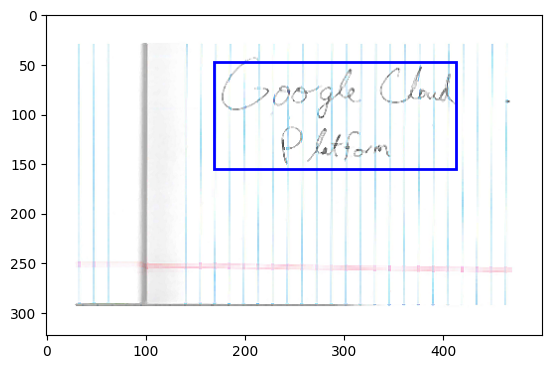

CER folosind Hamming 0.0 pe textul ['Google Cloud', 'Platform']
WER folosind Hamming 0.0 pe textul ['Google Cloud', 'Platform']
Distance levensthein 0
CER folosind Levenshtein 0.0 pe textul ['Google Cloud', 'Platform']
Distance levensthein 0
WER folosind Levenshtein 0.0 pe textul ['Google Cloud', 'Platform']


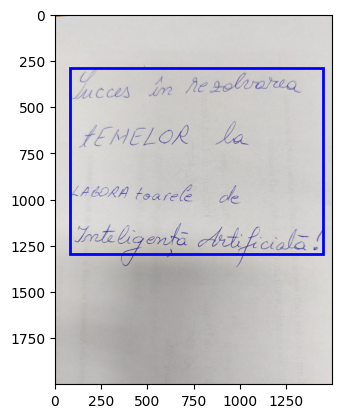

CER folosind Hamming 0.5428571428571428 pe textul ['Lucces in resolvarea', 'TEMELOR la', 'LABORA toarele de', 'Inteligenta Artificialà!']
WER folosind Hamming 0.8888888888888888 pe textul ['Lucces in resolvarea', 'TEMELOR la', 'LABORA toarele de', 'Inteligenta Artificialà!']
Distance levensthein 5
CER folosind Levenshtein 0.07142857142857142 pe textul ['Lucces in resolvarea', 'TEMELOR la', 'LABORA toarele de', 'Inteligenta Artificialà!']
Distance levensthein 6
WER folosind Levenshtein 0.6666666666666666 pe textul ['Lucces in resolvarea', 'TEMELOR la', 'LABORA toarele de', 'Inteligenta Artificialà!']


In [5]:
from PIL import Image, ImageFilter
import io

for filename, g in zip(os.listdir('images'), ground_truth):
    g: list
    img1 = Image.open('images/{}'.format(filename))
    img1 = img1.filter(ImageFilter.MedianFilter).filter(ImageFilter.SHARPEN)
    image_bytes = io.BytesIO()
    img1.save(image_bytes, format='JPEG')
    image_bytes.seek(0)
    read_response = get_response(image_bytes)
    read_result = get_read_result(read_response)
    points, result = get_data(read_result)
    min_x, min_y, max_x, max_y = points
    fig = matplotlib.pyplot.imshow(img1)
    fig.axes.add_patch(
        matplotlib.pyplot.Rectangle(xy=(min_x, min_y), width=max_x - min_x, height=max_y - min_y, fill=False,
                                    color="blue",
                                    linewidth=2))
    matplotlib.pyplot.show()
    new_g = []
    for l in g:
        a = l.split(" ")
        new_g.extend(a)
    new_result = []
    for l in result:
        a = l.split(" ")
        new_result.extend(a)
    print("CER folosind Hamming {} pe textul {}".format(er_hamming("".join(g), "".join(result)), result))
    print("WER folosind Hamming {} pe textul {}".format(er_hamming(new_g, new_result), result))
    print("CER folosind Levenshtein {} pe textul {}".format(er_lev("".join(g), "".join(result)), result))
    print("WER folosind Levenshtein {} pe textul {}".format(er_lev(new_g, new_result), result))

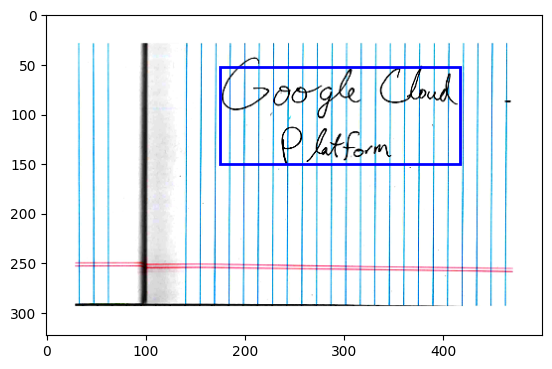

CER folosind Hamming 0.0 pe textul ['Google Cloud', 'Platform']
WER folosind Hamming 0.0 pe textul ['Google Cloud', 'Platform']
Distance levensthein 0
CER folosind Levenshtein 0.0 pe textul ['Google Cloud', 'Platform']
Distance levensthein 0
WER folosind Levenshtein 0.0 pe textul ['Google Cloud', 'Platform']


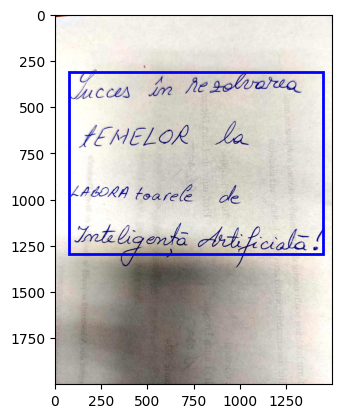

CER folosind Hamming 0.5571428571428572 pe textul ['Lucces in resolvarea', 'AENELOR la', 'LABORA toarele de', 'Inteligenta Artificialà!']
WER folosind Hamming 0.8888888888888888 pe textul ['Lucces in resolvarea', 'AENELOR la', 'LABORA toarele de', 'Inteligenta Artificialà!']
Distance levensthein 6
CER folosind Levenshtein 0.08571428571428572 pe textul ['Lucces in resolvarea', 'AENELOR la', 'LABORA toarele de', 'Inteligenta Artificialà!']
Distance levensthein 6
WER folosind Levenshtein 0.6666666666666666 pe textul ['Lucces in resolvarea', 'AENELOR la', 'LABORA toarele de', 'Inteligenta Artificialà!']


In [6]:
from PIL import Image, ImageEnhance
import io

for filename, g in zip(os.listdir('images'), ground_truth):
    img1 = Image.open('images/{}'.format(filename))
    img1 = ImageEnhance.Contrast(img1).enhance(3)
    image_bytes = io.BytesIO()
    img1.save(image_bytes, format='JPEG')
    image_bytes.seek(0)
    read_response = get_response(image_bytes)
    read_result = get_read_result(read_response)
    points, result = get_data(read_result)
    min_x, min_y, max_x, max_y = points
    fig = matplotlib.pyplot.imshow(img1)
    fig.axes.add_patch(
        matplotlib.pyplot.Rectangle(xy=(min_x, min_y), width=max_x - min_x, height=max_y - min_y, fill=False,
                                    color="blue",
                                    linewidth=2))
    matplotlib.pyplot.show()
    new_g = []
    for l in g:
        a = l.split(" ")
        new_g.extend(a)
    new_result = []
    for l in result:
        a = l.split(" ")
        new_result.extend(a)
    print("CER folosind Hamming {} pe textul {}".format(er_hamming("".join(g), "".join(result)), result))
    print("WER folosind Hamming {} pe textul {}".format(er_hamming(new_g, new_result), result))
    print("CER folosind Levenshtein {} pe textul {}".format(er_lev("".join(g), "".join(result)), result))
    print("WER folosind Levenshtein {} pe textul {}".format(er_lev(new_g, new_result), result))